# Imports and environment


In [76]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset

**Datased used is BCI Competition IVa**


In [77]:
dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["0train"]["0"]

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

# Create pipelines for SVM and LDA

**1** - CSP + SVM  
**2** - PSD + LDA


In [78]:
pipelines = {
    "csp+svm": make_pipeline(CSP(n_components=6), SVC(kernel="linear")),
    "psd+lda": make_pipeline(
        PSDEstimator(fmin=7, fmax=31, sfreq=250),
        FunctionTransformer(lambda X: X.reshape(X.shape[0], -1)),
        LDA(),
    ),
}

# Evaluate


In [79]:
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=[dataset], overwrite=True)
results = evaluation.process(pipelines)
results = results[results["session"] == "1test"]
results

2025-07-11 11:36:36,968 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]2025-07-11 11:36:40,196 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 1 | 0train: Score 0.952
2025-07-11 11:36:40,591 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 1 | 1test: Score 0.974
2025-07-11 11:36:41,391 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 1 | 0train: Score 0.791
2025-07-11 11:36:42,177 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 1 | 1test: Score 0.691
BNCI2014-001-CrossSession:  11%|█         | 1/9 [00:05<00:42,  5.32s/it]2025-07-11 11:36:45,482 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 2 | 0train: Score 0.551
2025-07-11 11:36:45,853 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 2 | 1test: Score 0.628
2025-07-11 11:36:46,613 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 2 | 0train:

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
1,0.974151,0.258027,144.0,1,1test,22,2,BNCI2014-001,csp+svm
3,0.628086,0.252013,144.0,2,1test,22,2,BNCI2014-001,csp+svm
5,0.993441,0.264006,144.0,3,1test,22,2,BNCI2014-001,csp+svm
7,0.836227,0.266009,144.0,4,1test,22,2,BNCI2014-001,csp+svm
9,0.611690,0.270017,144.0,5,1test,22,2,BNCI2014-001,csp+svm
11,0.783565,0.268011,144.0,6,1test,22,2,BNCI2014-001,csp+svm
13,0.885417,0.265950,144.0,7,1test,22,2,BNCI2014-001,csp+svm
15,0.994792,0.268009,144.0,8,1test,22,2,BNCI2014-001,csp+svm
17,0.970100,0.276315,144.0,9,1test,22,2,BNCI2014-001,csp+svm
19,0.690779,0.653026,144.0,1,1test,22,2,BNCI2014-001,psd+lda


# Plot SVM and LDA classifier results


(0.5, 1.0)

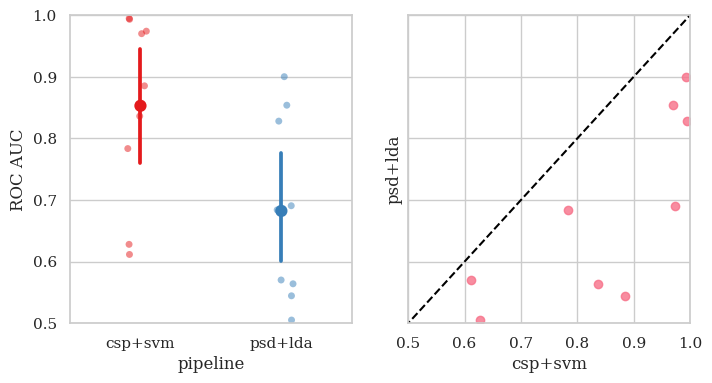

In [80]:
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="Set1")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(values="score", columns="pipeline", index=["subject", "session"])
paired = paired.reset_index()

sns.regplot(data=paired, y="psd+lda", x="csp+svm", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

# Prepare train and test data

The data is organised as follows:

- **X_all** - all data from epochs regarding left/right hand movement
- **y_all** - all labels from epochs regarding left/right hand movement
- **X_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing 4 sessions of each patient.
- **y_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing sessions' labels for each patient
- **X_test** - array of shape (n_subjects, ) where each element represents data from the last session of each subject
- **y_test** - array of shape (n_subjects, ) where each element represents labels from the last session of each subject


In [81]:
X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": -1, "right_hand": 1}

for idx, subject in enumerate(subjects):

    sess_1_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    sess_2_mask = (metadata["subject"] == subject) & (metadata["session"] == "1test")

    X_sess_1 = X_all[sess_1_mask]
    y_sess_1 = y_all[sess_1_mask]
    X_sess_2 = X_all[sess_2_mask]
    y_sess_2 = y_all[sess_2_mask]

    X_sess_1_feat = extract_welch_features(X_sess_1)
    y_sess_1 = np.array([label_map[label] for label in y_sess_1])
    X_sess_2_feat = extract_welch_features(X_sess_2)
    y_sess_2 = np.array([label_map[label] for label in y_sess_2])

    X_subject_train = np.empty(2, dtype=object)
    X_subject_train[0] = X_sess_1_feat[:72].T
    X_subject_train[1] = X_sess_1_feat[72:].T
    y_subject_train = np.empty(2, dtype=object)
    y_subject_train[0] = y_sess_1[:72].reshape(-1, 1)
    y_subject_train[1] = y_sess_1[72:].reshape(-1, 1)

    X_train[idx] = X_subject_train
    y_train[idx] = y_subject_train
    X_test[idx] = X_sess_2_feat.T
    y_test[idx] = y_sess_2.reshape(-1, 1)

2025-07-11 11:37:47,436 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:48,873 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:50,339 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:51,771 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:53,223 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:54,670 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:56,166 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:57,622 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:37:59,086 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:38:00,535 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:38:01,996 - INFO - Welch features extracted, vector's shape: (144, 176)
2025-07-11 11:38:03,455 - INFO - Welch features extrac

# Testing classifier across sessions (Algorithm 1)

First, classifier learns basic prior info based on first session of current patient.  
This creates a shared model with prior info.  
Then shared model is tested on second session of current patient.


In [97]:
accuracies = []
algorithm_1_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf = linear.MultiTaskLinearClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-07-11 12:22:32,493 - INFO - Iteration 1, error = 9.882842445296346
2025-07-11 12:22:32,525 - INFO - Iteration 2, error = 0.11871938652805435
2025-07-11 12:22:32,558 - INFO - Iteration 3, error = 0.013427420294218824
2025-07-11 12:22:32,590 - INFO - Iteration 4, error = 0.0015186703792005665
2025-07-11 12:22:32,623 - INFO - Iteration 5, error = 0.00017176491613168313
2025-07-11 12:22:32,655 - INFO - Iteration 6, error = 1.9426984834976435e-05
2025-07-11 12:22:32,688 - INFO - Iteration 7, error = 2.1972341644293603e-06
2025-07-11 12:22:32,720 - INFO - Iteration 8 converged, error = 2.485119589713808e-07
2025-07-11 12:22:32,721 - INFO - Accuracy for subject 0: 0.69
2025-07-11 12:22:32,753 - INFO - Iteration 1, error = 12.838844932130076
2025-07-11 12:22:32,786 - INFO - Iteration 2, error = 0.11889428169213907
2025-07-11 12:22:32,818 - INFO - Iteration 3, error = 0.016763871034447604
2025-07-11 12:22:32,859 - INFO - Iteration 4, error = 0.0023636744178214845
2025-07-11 12:22:32,890 - 

# Plot results (Algorithm 1)


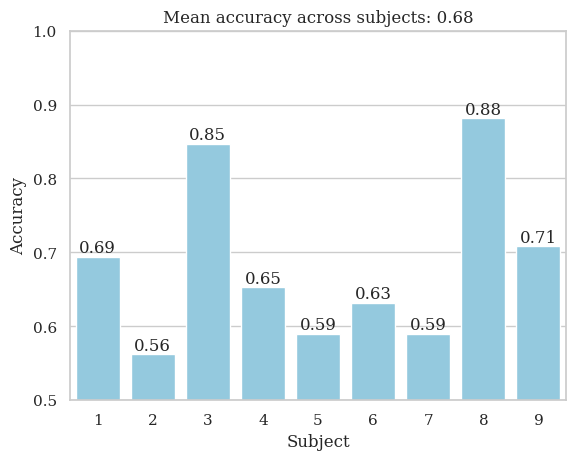

In [98]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.bar_label(axes.containers[0], fmt="%.2f")
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_1_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")
plt.show()

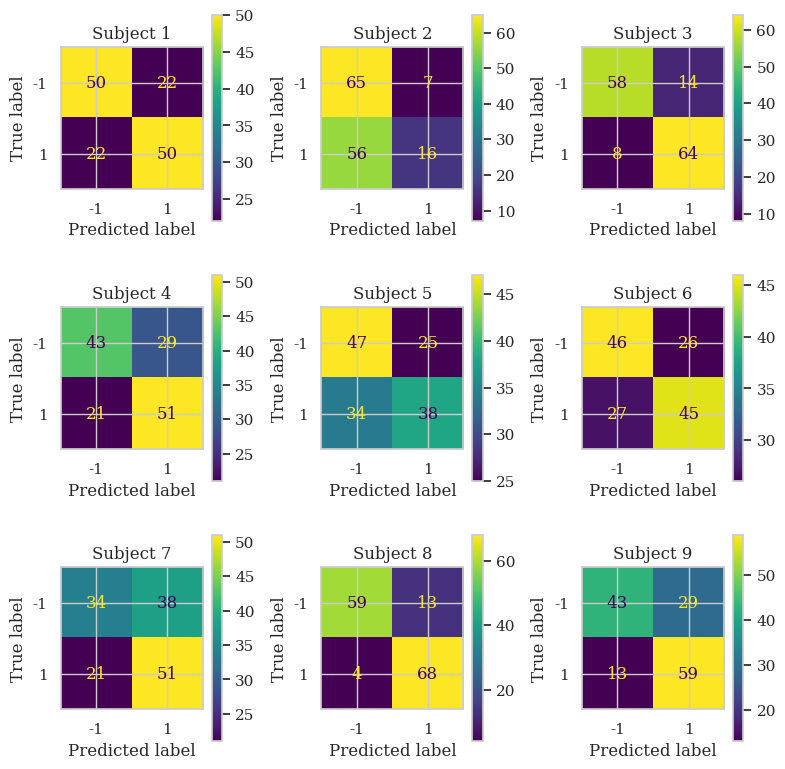

In [103]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Subject {subj_idx}")
plt.tight_layout()

# Testing classifier across sessions (Algorithm 2)

First, shared model is acquired the same way as for previous testing pipeline.  
Next, the second session is split into train and test data.  
The train data is used to calculate weight vector for this task and select prior vectors that match the new vector the most.  
Finally, the classifier is tested on the remaining data from second session.


In [101]:
def split_test_session(X: np.ndarray, y: np.ndarray):
    from sklearn.model_selection import train_test_split

    X_adapt, X_eval, y_adapt, y_eval = train_test_split(X.T, y, train_size=0.5, shuffle=True, random_state=42)
    return X_adapt.T, X_eval.T, y_adapt, y_eval


accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):

    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])

    X_adapt, X_eval, y_adapt, y_eval = split_test_session(X_test[idx], y_test[idx])
    clf.fit(X_adapt, y_adapt)
    acc, y_pred = clf.score(X_eval, y_eval)

    accuracies.append(acc)
    algorithm_2_results[f"subj_{idx+1}_test_labels"] = y_eval
    algorithm_2_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-07-11 12:37:55,858 - INFO - Iteration 1, error = 9.882842445296346
2025-07-11 12:37:55,892 - INFO - Iteration 2, error = 0.11871938652805435
2025-07-11 12:37:55,924 - INFO - Iteration 3, error = 0.013427420294218824
2025-07-11 12:37:55,957 - INFO - Iteration 4, error = 0.0015186703792005665
2025-07-11 12:37:55,988 - INFO - Iteration 5, error = 0.00017176491613168313
2025-07-11 12:37:56,020 - INFO - Iteration 6, error = 1.9426984834976435e-05
2025-07-11 12:37:56,052 - INFO - Iteration 7, error = 2.1972341644293603e-06
2025-07-11 12:37:56,084 - INFO - Iteration 8 converged, error = 2.485119589713808e-07
2025-07-11 12:37:56,093 - INFO - Selected 0 prior tasks out of 2 for new task adaptation.
2025-07-11 12:37:56,098 - INFO - Accuracy for subject 0: 0.71
2025-07-11 12:37:56,142 - INFO - Iteration 1, error = 12.838844932130076
2025-07-11 12:37:56,174 - INFO - Iteration 2, error = 0.11889428169213907
2025-07-11 12:37:56,207 - INFO - Iteration 3, error = 0.016763871034447604
2025-07-11 1

# Plot results (Algorithm 2)


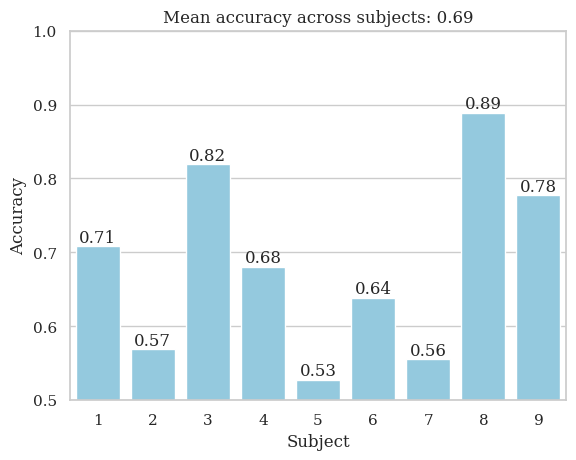

In [102]:
axes = sns.barplot(data=algorithm_2_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.bar_label(axes.containers[0], fmt="%.2f")
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_2_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")
plt.show()